# Analysis and Results

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Set directory
current_directory_path = r"C:\\Users\\atr8e/OneDrive/Documents/MSDS/2024_Spring/DS_6050/Project/Milestone_3/Models_and_Datasets/"
os.chdir(current_directory_path)

# ML Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Load Models

In [2]:
# Set path to the data and models
model_dir = [r"Ensemble_Model/", r"Dual_Model/", r"Four_Class_Model/"]

# Iterate through folders then files in each folder
for m_dir in model_dir:
    for file_name in os.listdir(m_dir):
        # Check if the file has .pkl extension
        if file_name.endswith('.keras'):
            # Load the pickle file
            file_path = os.path.join(m_dir, file_name)
            model = tf.keras.models.load_model(file_path)

            # Assign loaded model to variables with modified names
            # Remove .keras extension from the file name
            variable_name = os.path.splitext(file_name)[0]
            variable_name = m_dir[:-7] + "_" + variable_name.replace("FC_","")
            # Assign loaded data to variables with modified names
            globals()[f"{variable_name}"] = model

            # Optionally, you can print the loaded data for verification
            print(f"Loaded {variable_name}!")
        
print("Models are ready to use!")

Loaded Ensemble_CV_model!
Loaded Ensemble_Main_model!
Loaded Ensemble_PN_model!
Loaded Ensemble_TB_model!
Loaded Ensemble_Unbalanced_CV_model!
Loaded Ensemble_Unbalanced_Main_model!
Loaded Ensemble_Unbalanced_PN_model!
Loaded Ensemble_Unbalanced_TB_model!
Loaded Dual_Main_model!
Loaded Dual_UH_model!
Loaded Dual_Unbalanced_Main_model!
Loaded Dual_Unbalanced_UH_model!
Loaded Four_Class_model!
Loaded Four_Class_Unbalanced_model!
Models are ready to use!


# Load Test Image Data and Labels

In [3]:
# Set path to the data and models
dataset_dir = r"Four_Class_Model/"

# Iterate through files in the folder
for file_name in os.listdir(dataset_dir):
    # Check if the file has .pkl extension
    if file_name.endswith('test_unbalanced.pkl'):
        # Load the pickle file
        file_path = os.path.join(dataset_dir, file_name)
        with open(file_path, 'rb') as file:
            images, labels = pickle.load(file)
            
        # Convert to numpy arrays
        images, labels = np.array(images), np.array(labels)
        
        # Assign loaded data to variables with modified names
        # Remove .pkl extension from the file name
        variable_name = os.path.splitext(file_name)[0]
        # Remove the unbalanced part of the file name
        variable_name = variable_name[:-11]
        # Assign loaded data to variables with modified names
        globals()[f"{variable_name}_images"] = images
        globals()[f"{variable_name}_labels"] = labels

        # Optionally, you can print the loaded data for verification
        print(f"Loaded {variable_name}_images with length {images.shape}")
        print(f"Loaded {variable_name}_labels with length {len(labels)}")

Loaded four_class_test_images with length (1253, 256, 256)
Loaded four_class_test_labels with length 1253


#### Make sure data is ready for the models

In [4]:
# Make the data into an np.array
preprocessed_test_images = np.array([img for img in four_class_test_images])

# Ensure the images have the correct shape (add channel dimension for grayscale)
preprocessed_test_images = np.expand_dims(preprocessed_test_images, axis=-1)

# Consistency Across Models

#### Label Mapping

In [5]:
# Define a dictionary mapping numeric labels to class labels
label_mapping = {0: 'Healthy', 1: 'Pneumonia', 2: 'Covid', 3: 'Tuberculosis'}
class_mapping = {'Healthy': 0, 'Pneumonia': 1, 'Covid': 2, 'Tuberculosis': 3}

#### Confusion Matrix Function

In [6]:
def make_conf_matrix(df):
    # Create a confusion matrix
    df['Predicted_Class'] = df['Predicted_Class'].map(class_mapping)
    
    # Create a confusion matrix
    conf_matrix = confusion_matrix(df['True_Class'], df['Predicted_Class'])
    
    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()
    
    return conf_matrix

#### Model Performance Interpretation Function

In [24]:
def model_performance(conf_matrix):
    # Calculate true positives, true negatives, false positives, and false negatives
    tp = conf_matrix[1, 1] + conf_matrix[2, 2] + conf_matrix[3, 3]  # Sum of non-healthy classes (Pneumonia, Covid, Tuberculosis) on the diagonal
    tn = conf_matrix[0, 0]  # Healthy class
    fp = conf_matrix[0, 1:].sum()  # Sum of predictions as non-healthy classes (Pneumonia, Covid, Tuberculosis) when true label is Healthy
    fn = conf_matrix[1:, 0].sum()  # Sum of true labels as non-healthy classes (Pneumonia, Covid, Tuberculosis) when predicted label is Healthy

    # Calculate incorrect positives
    incorrect_positives = conf_matrix.sum()-tp-tn-fp-fn  # Subtract all else from total
    
    # Calculate accuracy
    accuracy = ((tp + tn) / conf_matrix.sum()) * 100
    binary_accuracy = ((tp + tn + incorrect_positives) / conf_matrix.sum()) * 100

    # Print the metrics
    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)
    print("Incorrect Positives:", incorrect_positives)
    print(f"Accuracy: {accuracy.round(2)}%")
    print(f"Healthy vs Unhealthy Accuracy: {binary_accuracy.round(2)}%")

# Four-Class Model
- test image data enters the main model
- the four-class model returns 3 values between 0 and 1 that add up to 1 

#### Predictions

In [8]:
# Make predictions
FC_predictions = Four_Class_model.predict(preprocessed_test_images)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step


#### Dataframe

In [9]:
# Create a DataFrame to store the predictions along with the true labels
df_fc_predictions = pd.DataFrame(FC_predictions, columns=['Healthy', 'Pneumonia', 'Covid', 'Tuberculosis'])
df_fc_predictions['True_Class'] = four_class_test_labels

# Find the predicted class for each row based on the highest probability
df_fc_predictions['Predicted_Class'] = df_fc_predictions[['Healthy', 'Pneumonia', 'Covid', 'Tuberculosis']].idxmax(axis=1)
df_fc_predictions.drop(columns=['Healthy', 'Pneumonia', 'Covid', 'Tuberculosis'], inplace=True)

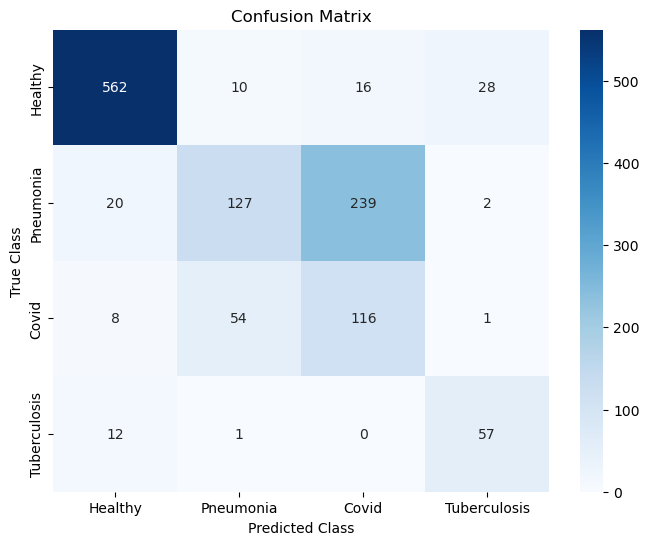

In [10]:
fc_cm = make_conf_matrix(df_fc_predictions)

In [25]:
model_performance(fc_cm)

True Positives: 300
True Negatives: 562
False Positives: 54
False Negatives: 40
Incorrect Positives: 297
Accuracy: 68.79%
Healthy vs Unhealthy Accuracy: 92.5%


# Dual Model Logic Flow
- test image data enters the main model
- the main model produces a binary value of 1 or 0 for unhealthy vs healthy
- the test image data for unhealthy images are passed through the three-class model
- the three class model returns 3 values between 0 and 1 that add up to 1

#### Predictions

In [12]:
# Use the first model to predict whether the lung is healthy or unhealthy
main_predictions = Dual_Unbalanced_Main_model.predict(preprocessed_test_images)

# Convert the predictions to binary values (0 for healthy, 1 for unhealthy)
is_unhealthy = (main_predictions >= 0.5).astype(int)

# Initialize an empty list to store final predictions
dual_predictions = []

# Iterate through the predictions
for idx, prediction in enumerate(main_predictions):
    if idx % 200 == 0:
        print(f"{idx}/{len(preprocessed_test_images)}")
    if is_unhealthy[idx] == 0:
        dual_predictions.append((0, 0))
    else:
        uh_prediction = Dual_UH_model.predict(preprocessed_test_images[idx:idx+1], verbose=0)  
        disease_class = np.argmax(uh_prediction, axis=1)[0]+1 # Convert to class label
        dual_predictions.append((is_unhealthy[idx][0], disease_class))

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step
0/1253
200/1253
400/1253
600/1253
800/1253
1000/1253
1200/1253


#### Dataframe

In [13]:
# Convert the dual predictions to a DataFrame
df_dual_predictions = pd.DataFrame(dual_predictions, columns=['Main_Model_Prediction', 'Predicted_Class'])# 'Secondary_Model_Prediction'])
df_dual_predictions['True_Class'] = four_class_test_labels
df_dual_predictions['Predicted_Class'] = df_dual_predictions['Predicted_Class'].map(label_mapping)
df_dual_predictions.drop(columns=['Main_Model_Prediction'], inplace=True)


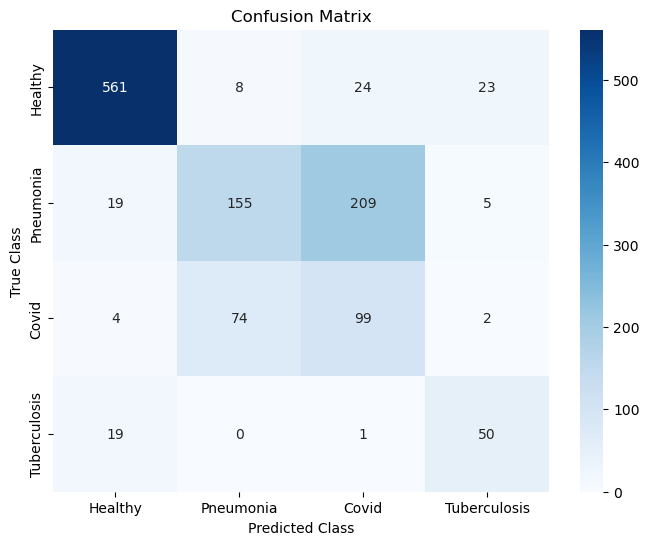

In [14]:
dual_cm = make_conf_matrix(df_dual_predictions)

In [26]:
model_performance(dual_cm)

True Positives: 304
True Negatives: 561
False Positives: 55
False Negatives: 42
Incorrect Positives: 291
Accuracy: 69.03%
Healthy vs Unhealthy Accuracy: 92.26%


# Ensemble Model Logic Flow
- test image data enters the main model
- the main model produces a binary value of 1 or 0 for unhealthy vs healthy
- the test image data for unhealthy images are passed through the three disease models
- each disease model returns a value between 0 and 1
- the model that has the highest value is deemed the correct disease
- play with thresholds to determine if it we can reduce false-positives

#### Predictions

In [16]:
# Use the first model to predict whether the lung is healthy or unhealthy
main_predictions = Ensemble_Unbalanced_Main_model.predict(preprocessed_test_images)

# Convert the predictions to binary values (0 for healthy, 1 for unhealthy)
is_unhealthy = (main_predictions >= 0.5).astype(int)

# Initialize an empty list to store final predictions
ensemble_predictions = []

# Iterate through the predictions
for idx, prediction in enumerate(main_predictions):
    if idx % 200 == 0:
        print(f"{idx}/{len(preprocessed_test_images)}")
    if is_unhealthy[idx] == 0:
        ensemble_predictions.append((0, 0, 0, 0))
    else:
        pn_prediction = Ensemble_PN_model.predict(preprocessed_test_images[idx:idx+1], verbose=0)
        cv_prediction = Ensemble_CV_model.predict(preprocessed_test_images[idx:idx+1], verbose=0)
        tb_prediction = Ensemble_Unbalanced_TB_model.predict(preprocessed_test_images[idx:idx+1], verbose=0)
        ensemble_predictions.append((is_unhealthy[idx][0], pn_prediction[0][0], cv_prediction[0][0], tb_prediction[0][0]))

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step
0/1253
200/1253
400/1253
600/1253
800/1253
1000/1253
1200/1253


#### Dataframe

In [17]:
# Create a DataFrame to store the predictions along with the true labels
df_ensemble_predictions = pd.DataFrame(ensemble_predictions, columns=['Healthy', 'Pneumonia', 'Covid', 'Tuberculosis'])
df_ensemble_predictions['True_Class'] = four_class_test_labels

# Find the predicted class for each row based on the highest probability
# Function to determine predicted class
def determine_predicted_class(row):
    if row['Healthy'] == 0:
        return 'Healthy'
    else:
        # Get the column name with the highest value among 'Pneumonia', 'Covid', 'Tuberculosis'
        max_column = max(['Pneumonia', 'Covid', 'Tuberculosis'], key=lambda col: row[col])
        return max_column

# Apply the function row-wise to create the 'Predicted_Class' column
df_ensemble_predictions['Predicted_Class'] = df_ensemble_predictions.apply(determine_predicted_class, axis=1)

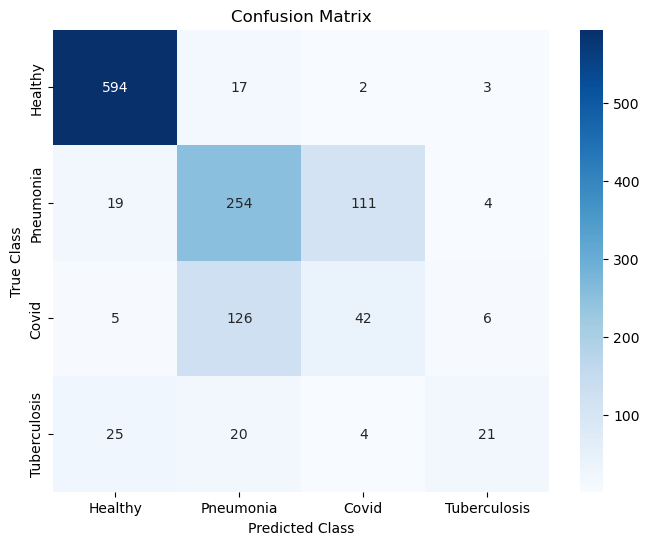

In [18]:
ensemble_cm = make_conf_matrix(df_ensemble_predictions)

In [27]:
model_performance(ensemble_cm)

True Positives: 317
True Negatives: 594
False Positives: 22
False Negatives: 49
Incorrect Positives: 271
Accuracy: 72.71%
Healthy vs Unhealthy Accuracy: 94.33%


# Ensemble Model (w/o main) Logic Flow

#### Predictions

In [20]:
# Initialize an empty list to store final predictions
experimental_predictions = []

pn_prediction = Ensemble_PN_model.predict(preprocessed_test_images)
cv_prediction = Ensemble_CV_model.predict(preprocessed_test_images)
tb_prediction = Ensemble_Unbalanced_TB_model.predict(preprocessed_test_images)

for i in range(len(preprocessed_test_images)):
    experimental_predictions.append((pn_prediction[i][0], cv_prediction[i][0], tb_prediction[i][0]))

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step


#### Dataframe

In [21]:
# Create a DataFrame to store the predictions along with the true labels
df_experimental_predictions = pd.DataFrame(experimental_predictions, columns=['Pneumonia', 'Covid', 'Tuberculosis'])

# Find the predicted class for each row based on the highest probability
# Function to determine predicted class
def determine_predicted_class(row):
    if all(row[['Pneumonia', 'Covid', 'Tuberculosis']] < 0.99):
        return 'Healthy'
    else:
        # Get the column name with the highest value among 'Pneumonia', 'Covid', 'Tuberculosis'
        max_column = max(['Pneumonia', 'Covid', 'Tuberculosis'], key=lambda col: row[col])
        return max_column

# Apply the function row-wise to create the 'Predicted_Class' column
df_experimental_predictions['Predicted_Class'] = df_experimental_predictions.apply(determine_predicted_class, axis=1)
df_experimental_predictions['True_Class'] = four_class_test_labels

# Print or display the updated DataFrame
print(df_experimental_predictions)

         Pneumonia         Covid  Tuberculosis Predicted_Class  True_Class
0     5.794804e-08  1.807698e-08  4.320176e-04         Healthy           0
1     7.638381e-04  2.932673e-06  2.549996e-02         Healthy           0
2     7.866924e-09  6.614876e-10  1.415384e-07         Healthy           0
3     1.766250e-04  1.393734e-07  9.690884e-01         Healthy           0
4     1.055684e-09  4.701377e-11  4.296983e-07         Healthy           0
...            ...           ...           ...             ...         ...
1248  9.995582e-01  9.147514e-01  7.346697e-02       Pneumonia           3
1249  9.999134e-01  2.131780e-01  9.707199e-01       Pneumonia           3
1250  7.215746e-05  2.572152e-01  6.785408e-01         Healthy           3
1251  9.999987e-01  2.401273e-01  9.999982e-01       Pneumonia           3
1252  9.999968e-01  2.358888e-01  6.196537e-01       Pneumonia           3

[1253 rows x 5 columns]


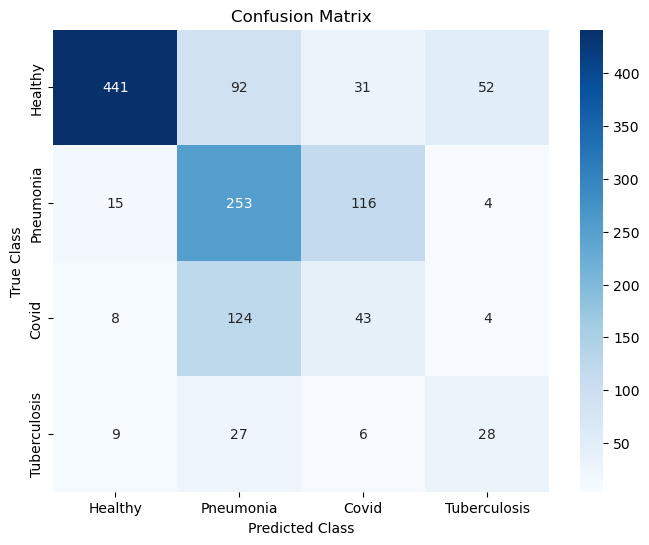

In [22]:
experimental_cm = make_conf_matrix(df_experimental_predictions)

In [28]:
model_performance(experimental_cm)

True Positives: 324
True Negatives: 441
False Positives: 175
False Negatives: 32
Incorrect Positives: 281
Accuracy: 61.05%
Healthy vs Unhealthy Accuracy: 83.48%
